In [54]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K
from matplotlib import pyplot as plt

In [57]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [8]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

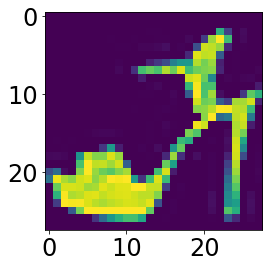

In [224]:
plt.imshow(X_train[9].reshape([28,28]))

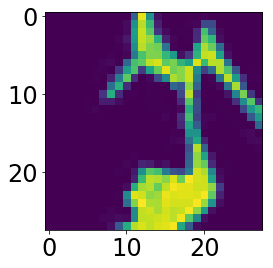

In [225]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

Начнем исследовать нашу нейронку. Для начала, напишем несколько функций, которые нам пригодятся в дальнейшем.

In [201]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

Эта функция принимает массив картинок и возвращает массив повернутых на угол `angle` картинок

In [202]:
def get_X_and_y(base_dataset, angle):
    rotated_dataset = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_dataset)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


Одна из основных функций: принимает картинки и угол, после чего возвращает перемешанные картинки и повернутые на угол `angle` картинки вместе с правильными ответами `whole_labels` - повернута или нет.

In [203]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

Рестартит модель `model` для повторного обучения

In [215]:
def get_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer([784]))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax'))
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    return model

batch_size = 128
n_epochs = 40

Создает фиксированную модель и задает пару констант для нее

In [235]:
tests_for_angle = 8

Количество тестов для каждого угла

In [236]:
from ipywidgets import FloatProgress
from IPython.display import display
#Status bar importing

In [237]:
angles = np.linspace(0, 360, 20)
angle_accuracies = []
f = FloatProgress(min=0, max=100)
display(f)
d = 100 / angles[-1]
for angle in angles:
    f.value = angle * d
    accuracy_store = []
    model = get_model()
    for _ in range(tests_for_angle):
        base_indices = np.random.choice(np.arange(X_train.shape[0]), size=500, replace=False)
        base_dataset = X_train[base_indices].reshape([-1, 28,28])
        test_indices = np.random.choice(np.arange(X_test.shape[0]), size=X_test.shape[0]//2, replace=False)
        test_dataset = X_test[test_indices].reshape([-1, 28,28])
        X, y = get_X_and_y(base_dataset, angle)
        X_test_whole, y_test_whole = get_X_and_y(test_dataset, angle)
        model.fit(X, y,
                  batch_size=batch_size,
                  epochs=n_epochs,
                  verbose=0)
        accuracy_store.append(accuracy_score(y_test_whole[:, 1], model.predict_classes(X_test_whole)))
        reset_weights(model)
    accuracy_store = np.array(accuracy_store)
    mean = np.mean(accuracy_store)
    disp = np.std(accuracy_store) ** 2
    angle_accuracies.append([mean, disp])

FloatProgress(value=0.0)

Тут мы запускаем первые тесты. Стараемся охватить картину в целом: как нейронка ведет себя на всех углах. Для этого создаем массив углов от 0 до 360 длиной 20. Для каждого угла проводим по `tests_for_angle` тестов, высчитываем по ним среднюю ошибку и ее дисперсию. Каждый тест обучается на 500 случайных картинок датасета + 500 их повернутых копий. **Accuracy** вычисляется по случайной половине из датасета проверки

Text(0.5, 0, 'angle')

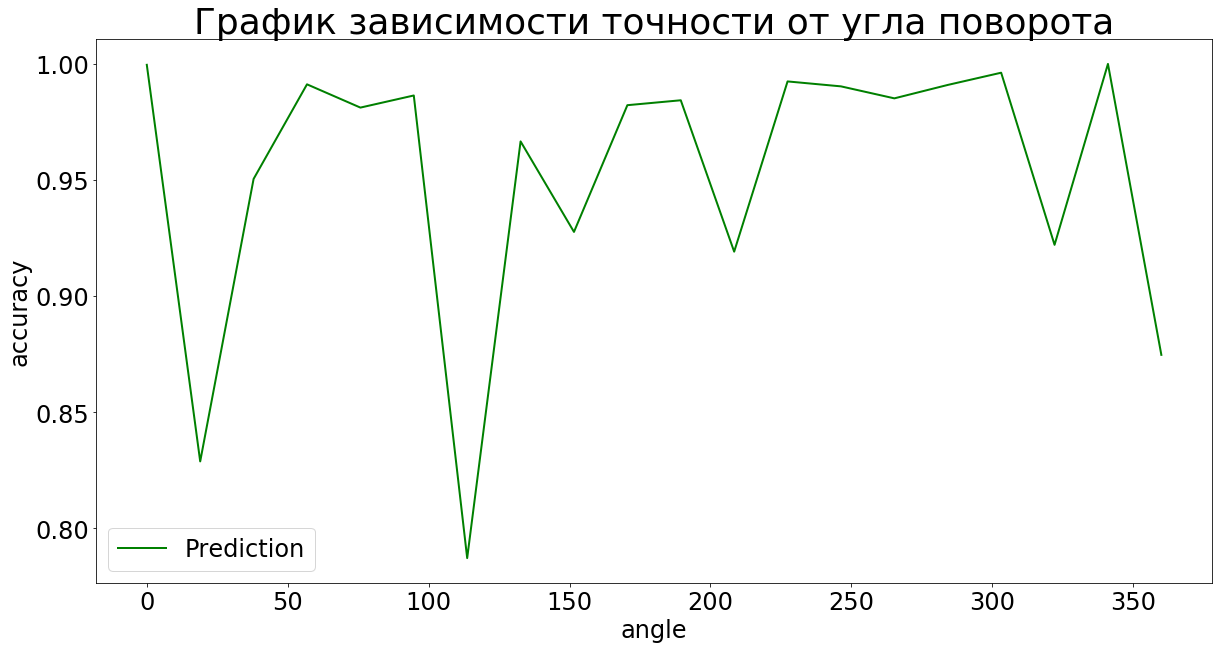

In [239]:
fig, ax = plt.subplots(nrows=1,figsize=(20, 10))

ax.plot(angles, a[:,0], label=r'Prediction', color='green')
ax.legend()
ax.set_title(r'График зависимости точности от угла поворота') 
ax.set_ylabel('accuracy')
ax.set_xlabel('angle')

По графику точности видно, что чем ближе к нулю, тем менее уверенной выходит нейросеть. Поссмотрим на дисперсию.

Text(0.5, 0, 'angle')

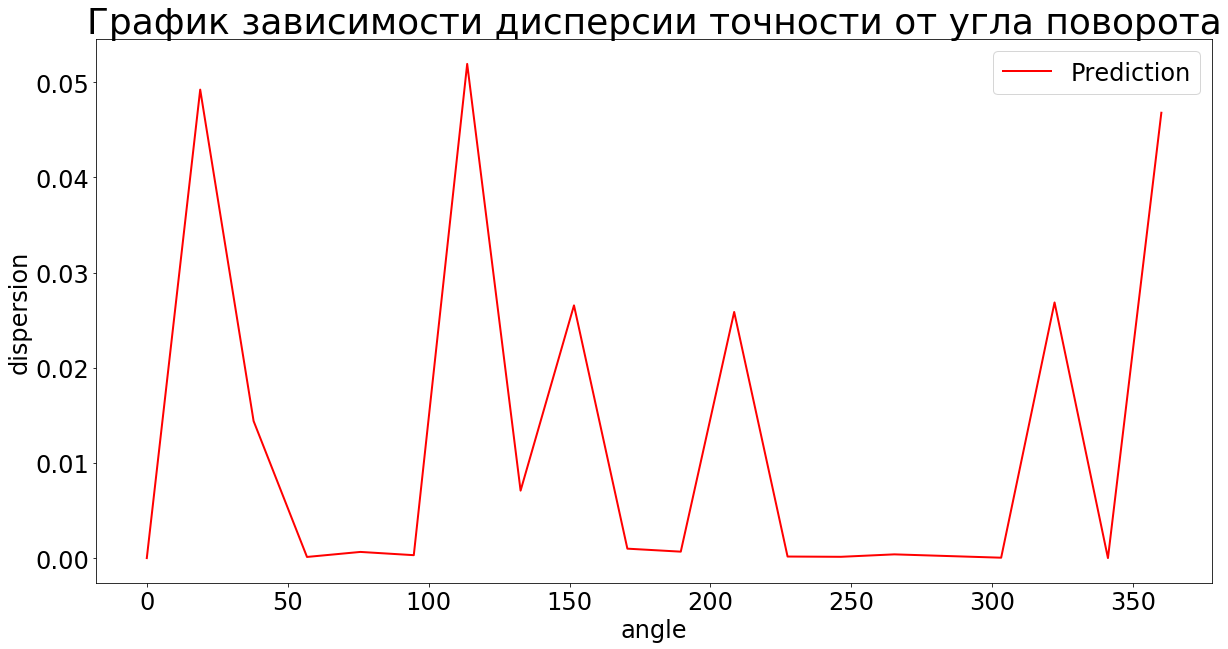

In [240]:
fig, ax = plt.subplots(nrows=1,figsize=(20, 10))
ax.plot(angles, a[:,1], label=r'Prediction', color='red')
ax.legend()
ax.set_title(r'График зависимости дисперсии точности от угла поворота') 
ax.set_ylabel('dispersion')
ax.set_xlabel('angle')

Дисперсия оказывается не очень большой для всех углов. Но и тут видна нехорошая тенденция при приближении к нулю. Рассмотрим поближе, что там происходит

In [245]:
tests_for_angle = 16

Увеличим количество тестов для уверенности

In [246]:
angles = np.linspace(0, 9, 10)
angle_accuracies = []
f = FloatProgress(min=0, max=100)
display(f)
d = 100 / angles[-1]
for angle in angles:
    f.value = angle * d
    accuracy_store = []
    model = get_model()
    for _ in range(tests_for_angle):
        base_indices = np.random.choice(np.arange(X_train.shape[0]), size=500, replace=False)
        base_dataset = X_train[base_indices].reshape([-1, 28,28])
        test_indices = np.random.choice(np.arange(X_test.shape[0]), size=X_test.shape[0]//2, replace=False)
        test_dataset = X_test[test_indices].reshape([-1, 28,28])
        X, y = get_X_and_y(base_dataset, angle)
        X_test_whole, y_test_whole = get_X_and_y(test_dataset, angle)
        model.fit(X, y,
                  batch_size=batch_size,
                  epochs=n_epochs,
                  verbose=0)
        accuracy_store.append(accuracy_score(y_test_whole[:, 1], model.predict_classes(X_test_whole)))
        reset_weights(model)
    accuracy_store = np.array(accuracy_store)
    mean = np.mean(accuracy_store)
    disp = np.std(accuracy_store) ** 2
    angle_accuracies.append([mean, disp])

FloatProgress(value=0.0)

Тут происходит все то же, что и раньше, но мы сузили массив углов до 10 на промежутке от 0 до 9.

In [247]:
b = np.array(angle_accuracies)

Text(0.5, 0, 'angle')

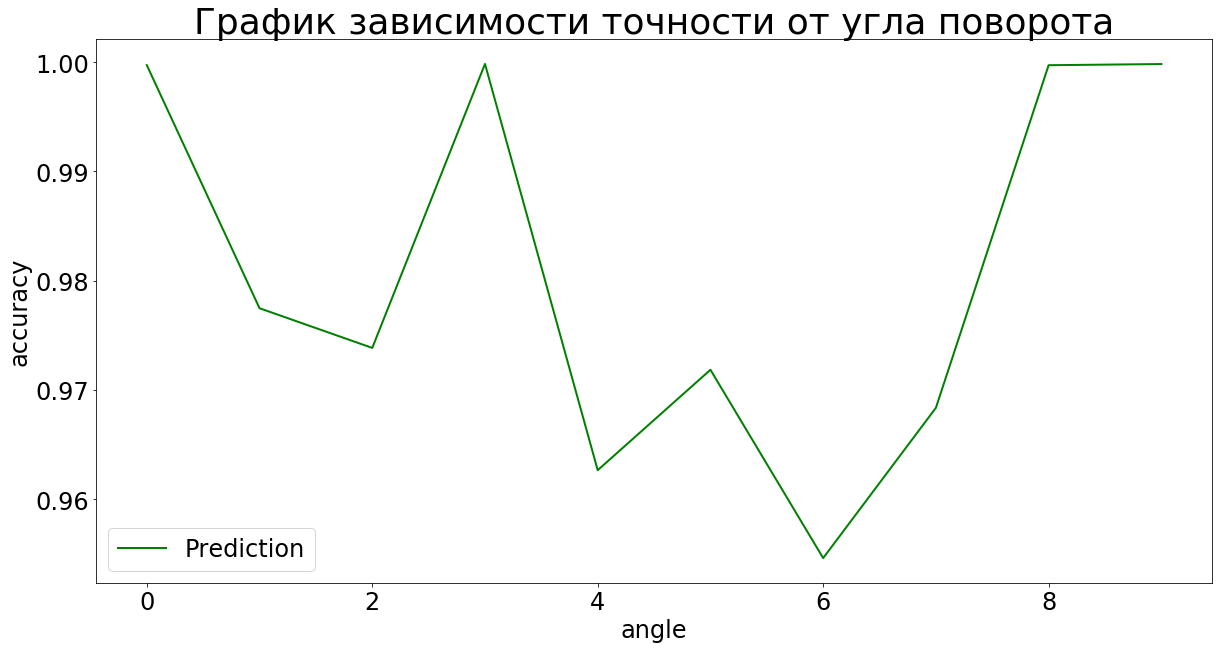

In [248]:
fig, ax = plt.subplots(nrows=1,figsize=(20, 10))

ax.plot(angles, b[:,0], label=r'Prediction', color='green')
ax.legend()
ax.set_title(r'График зависимости точности от угла поворота') 
ax.set_ylabel('accuracy')
ax.set_xlabel('angle')

Ну что тут сказать. Видать наша нейронка слишком хороша

Text(0.5, 0, 'angle')

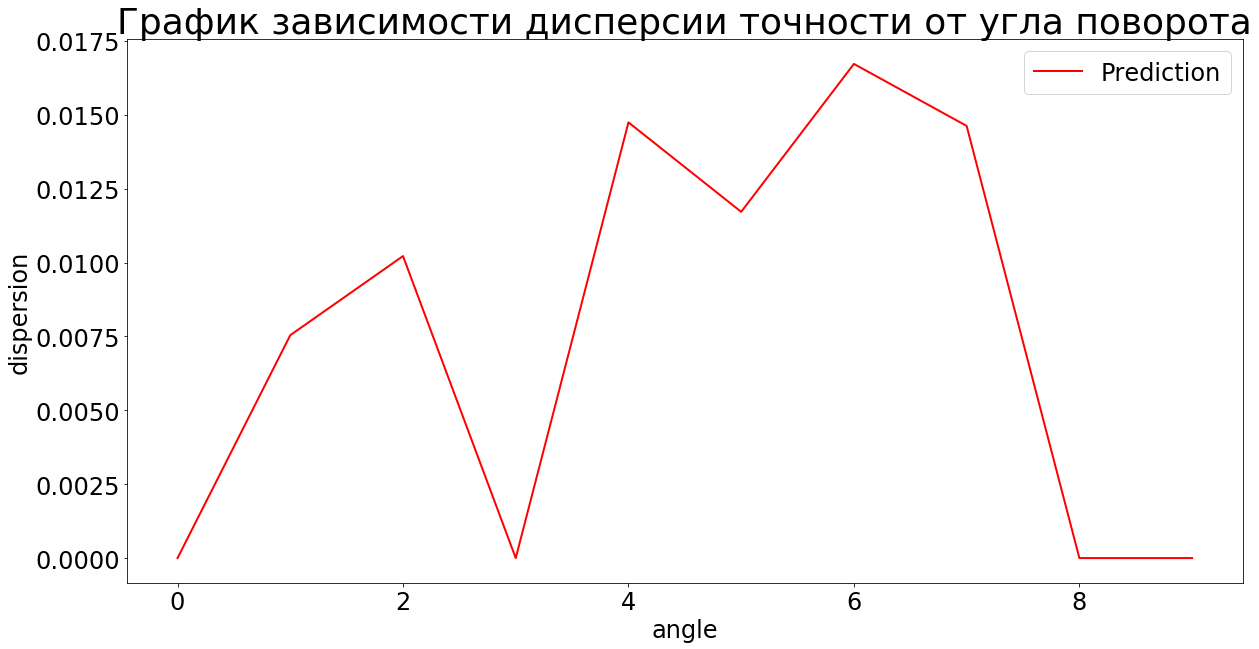

In [249]:
fig, ax = plt.subplots(nrows=1,figsize=(20, 10))
ax.plot(angles, b[:,1], label=r'Prediction', color='red')
ax.legend()
ax.set_title(r'График зависимости дисперсии точности от угла поворота') 
ax.set_ylabel('dispersion')
ax.set_xlabel('angle')

Судя по графикам, наша нейронка показывает себя хорошо на всем множестве углов, что звучит слишком хорошо. Конечно, стоит отметить, что мы давали ей послабление в том, что и обучали и тестировали ее на константных углах.